<div class="alert alert-info">

#### **Dataset Analysis**

This notebook will analyze and summarize all different aspects of the dataset.

</div>

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import tqdm
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from enum import IntEnum
from datetime import timedelta

from video_dataset import VideoDataset
from video_dataset.padder import LastValuePadder
from video_dataset.dataset import VideoShapeComponents
from video_dataset.video import VideoFromVideoFramesDirectory
from video_dataset.preprocessor import extract_frames_from_videos
from video_dataset.annotations import AnnotationsFromSegmentLevelCsvFileAnnotations

from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.scores import repetition_score, order_variation_score
from tas_helpers.metrics import mean_over_frames, f1_score, edit_distance

from cached_dataset.dataset import DiskCachedDataset

from bouldering_video_segmentation.utils import LabelEncoderFactory

In [36]:
from experiments.helpers.plots_formatting import ICML

In [37]:
# import scienceplots

# plt.style.use("ieee")

In [38]:
VIDEO_FPS = 25

DATASET_PATH = "/Users/nadir/Documents/research-project-dataset"

VIDEOS_DIRECTORY_NAME = "videos"
ANNOTATIONS_DIRECTORY_NAME = "annotations"
VIDEOS_FRAMES_DIRECTORY_NAME = "videos_frames"

ALL_IDS_FILE_NAME = "all_ids.txt"
TESTING_IDS_FILE_NAME = "testing_ids.txt"
TRAINING_IDS_FILE_NAME = "training_ids.txt"
VALIDATION_IDS_FILE_NAME = "validation_ids.txt"

ANNOTATED_IDS_FILE_NAME = "annotated_ids.txt"
UNANNOTATED_IDS_FILE_NAME = "unannotated_ids.txt"

In [39]:
label_encoder = LabelEncoderFactory.get()

In [40]:
def __aggregate_labels(str_labels):
    labels = label_encoder.transform(str_labels)
    
    unique_elements, counts = np.unique(labels, return_counts=True)

    max_count_index = np.argmax(counts)

    most_frequent_element = unique_elements[max_count_index]
    
    return most_frequent_element

In [41]:
all_videos_dataset = VideoDataset(
    annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
    ids_file=os.path.join(DATASET_PATH, ALL_IDS_FILE_NAME),
    segment_size=32,
    video_processor=VideoFromVideoFramesDirectory,
    annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
    annotations_processor_kwargs={"fps": VIDEO_FPS, "delimiter": ","},
    video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
    step=1,
    # padder=LastValuePadder(),
    annotations_transform=__aggregate_labels,
    overlap=0,
    allow_undefined_annotations=True,
    verbose=False
)

In [42]:
annotated_segments_dataset = VideoDataset(
    annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
    ids_file=os.path.join(DATASET_PATH, ANNOTATED_IDS_FILE_NAME),
    segment_size=32,
    video_processor=VideoFromVideoFramesDirectory,
    annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
    annotations_processor_kwargs={"fps": VIDEO_FPS, "delimiter": ","},
    video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
    step=1,
    # padder=LastValuePadder(),
    # annotations_transform=__aggregate_labels,
    overlap=0,
    allow_undefined_annotations=True,
    load_videos=True
)

annotated_videos_dataset = VideoDataset(
    annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
    ids_file=os.path.join(DATASET_PATH, ANNOTATED_IDS_FILE_NAME),
    segment_size=VideoDataset.FULL_VIDEO_SEGMENT,
    video_processor=VideoFromVideoFramesDirectory,
    annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
    annotations_processor_kwargs={"fps": VIDEO_FPS, "delimiter": ","},
    video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
    step=1,
    # padder=LastValuePadder(),
    # annotations_transform=__aggregate_labels,
    overlap=0,
    allow_undefined_annotations=True,
    load_videos=False
)

[warning]: 13 frames will be lost, because video climb_9-climber_MasseQuentin-bloc_1-angle_face@0 has 5869 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 21 frames will be lost, because video climb_11-climber_MoubeAdrian-bloc_2-angle_profile@1 has 6261 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 20 frames will be lost, because video climb_2-climber_MrideEsteban-bloc_1-angle_profile@2 has 6260 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 10 frames will be lost, because video climb_15-climber_ChatagonMael-bloc_2-angle_profile@3 has 6314 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 31 frames will be lost, because video climb_4-climber_PlancheLeo-bloc_1-angle_profile@4 has 6047 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 23 frames will be lost, because video climb_13-climber_FonneLan

In [43]:
print(f"[dataset-size]: {len(annotated_videos_dataset)}")

[dataset-size]: 22


<div class="alert alert-info">

#### **Dataset Total Duration:**

</div>

In [44]:
fps = VIDEO_FPS

all_annotations = [annotation for _, video_annotations in annotated_videos_dataset for annotation in video_annotations]

total_number_of_frames = len(all_annotations)

duration = total_number_of_frames / fps
formatted_duration = str(timedelta(seconds=int(duration)))

print(f"[total_number_of_frames]: {total_number_of_frames}")
print(f"--- --- ---")
print(f"[duration(hours:minutes:seconds)]: {formatted_duration}")

[total_number_of_frames]: 133490
--- --- ---
[duration(hours:minutes:seconds)]: 1:28:59


<div class="alert alert-info">

#### **Repetition Score:**

</div>

In [45]:
repetition_scores = [repetition_score(annotations) for _, annotations in annotated_videos_dataset]

average_repetition_score = np.mean(repetition_scores)
std_repetition_score = np.std(repetition_scores)
    
print(f"[repetition-score]: {average_repetition_score} ± {std_repetition_score}")

[repetition-score]: 0.8131712451488049 ± 0.03650003778074824


<div class="alert alert-warning">

The repetition score ranges between 0 and -1. A higher value such as in our case signifies a higher degree of repetition within the sequences. In simple words, actions usually repeat in the sequence / activity.

</div>

<div class="alert alert-info">

#### **Order Variation Score:**

</div>

In [46]:
videos_annotations = [annotations for _, annotations in annotated_videos_dataset]

order_variation_scores = order_variation_score(videos_annotations)

In [47]:
print(f"[order_variation_scores]: {order_variation_scores}")

[order_variation_scores]: 0.49168006853134416


<div class="alert alert-warning">

The repetition score ranges between 0 and -1. A higher value such as in our case signifies a higher degree of repetition within the sequences. In simple words, actions usually repeat in the sequence / activity.

</div>

<div class="alert alert-info">

#### **No Human Proportion:**

The proportion of frames where no one is present or multiple persons are present.


</div>

In [48]:
yolo_dataset = DiskCachedDataset(
    base_path=os.path.join(DATASET_PATH, "features/yolo"),
)

total_frames_with_persons = 0

for features, label, _, _ in yolo_dataset:
    persons_count = 0
    
    for frame_features in features:
        if frame_features.sum() != 0:
            persons_count += 1
    
    # NOTE: to average over 32 frames rather than 8
    persons_count = persons_count * 4
    
    total_frames_with_persons += persons_count
    
print(f"[total_frames]: {len(yolo_dataset) * 32}")
print(f"[total_frames_with_persons]: {total_frames_with_persons}")

percentage_of_frames_without_persons = 1 - (total_frames_with_persons / (len(yolo_dataset) * 32))

print(f"[percentage_of_frames_without_persons]: {(percentage_of_frames_without_persons * 100):.02f}%")

[total_frames]: 131136
[total_frames_with_persons]: 113520
[percentage_of_frames_without_persons]: 13.43%


In [49]:
yolo_dataset = DiskCachedDataset(
    base_path=os.path.join(DATASET_PATH, "features/yolo"),
)

total_frames_with_persons = {
    "brossage": 0,
    "chrono": 0,
    "grimpe": 0,
    "lecture": 0,
    "nothing": 0
}

for features, label, _, _ in yolo_dataset:
    persons_count = 0
    
    label = label[0]
    
    for frame_features in features:
        if frame_features.sum() != 0:
            persons_count += 1
    
    # NOTE: to average over 32 frames rather than 8
    persons_count = persons_count * 4
    
    # total_frames_with_persons += persons_count
    
    if total_frames_with_persons.get(label_encoder.inverse_transform([label])[0]) is None:
        total_frames_with_persons[label_encoder.inverse_transform([label])[0]] = persons_count
    else:
        total_frames_with_persons[label_encoder.inverse_transform([label])[0]] += persons_count
    
total = sum(total_frames_with_persons.values())

print(total)

# print(f"[total_frames]: {len(yolo_dataset) * 32}")
# print(f"[total_frames_with_persons]: {total_frames_with_persons}")

# percentage_of_frames_without_persons = 1 - (total_frames_with_persons / (len(yolo_dataset) * 32))

# print(f"[percentage_of_frames_without_persons]: {(percentage_of_frames_without_persons * 100):.02f}%")

113520


# Dataset Loss without "Nothing" class and "Personless" Frames

<div class="alert alert-info">

#### **Actions Durations:**



</div>

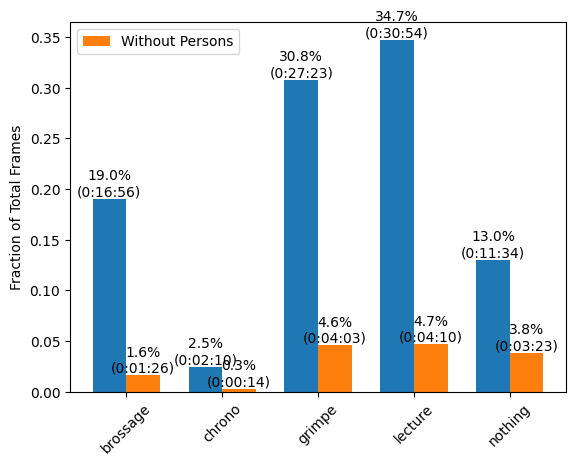

In [62]:
all_annotations = [annotation for _, video_annotations in annotated_videos_dataset for annotation in video_annotations]

unique_classes, counts = np.unique(all_annotations, return_counts=True)
total_frames = len(all_annotations)

fractions = counts / total_frames

durations = [str(timedelta(seconds=int(count/fps))) for count in counts]

# personless_durations = [str(timedelta(seconds=int((total_frames - count) / fps))) for count in counts]
personless_durations = [
    str(timedelta(seconds=int((count - total_frames_with_persons[class_name]) / fps)))
    for count, class_name in zip(counts, unique_classes)
]

width = 0.35
x = np.arange(len(unique_classes))

plt.figure(figsize=ICML.single_column_figure())

plt.bar(x - width / 2, fractions, width=width)
plt.bar(x + width / 2, (counts - np.array(list(total_frames_with_persons.values()))) / total_frames, width=width, label='Without Persons')

# plt.title('Distribution of Actions in Dataset')
plt.ylabel('Fraction of Total Frames')
plt.xticks(x, unique_classes, rotation=45)

for i, (v, d) in enumerate(zip(fractions, durations)):
    plt.text(i - width / 2, v, f'{v:.1%}\n({d})', ha='center', va='bottom')
for i, (v, d) in enumerate(zip((counts - np.array(list(total_frames_with_persons.values()))) / total_frames, 
                            personless_durations)):
    plt.text(i + width / 2, v, f'{v:.1%}\n({d})', ha='center', va='bottom')

plt.legend()

plt.savefig("../assets/figures/distribution-of-actions-in-dataset.png")

plt.show()

<div class="alert alert-info">

#### **Average Action Duration:**

</div>

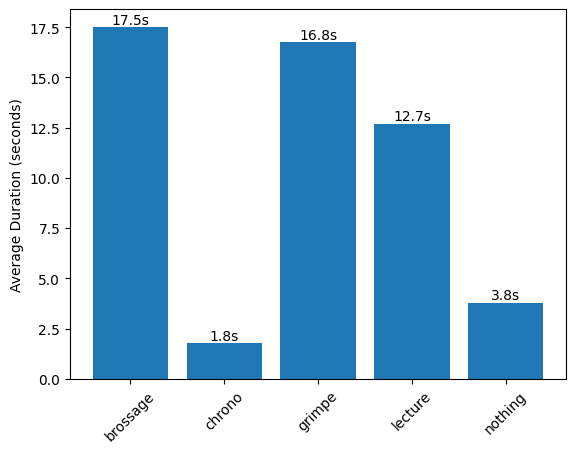

In [61]:
average_durations = []
for class_name, count in zip(unique_classes, counts):
    sequences = []
    current_sequence = 0
    
    for annotation in all_annotations:
        if annotation == class_name:
            current_sequence += 1
        elif current_sequence > 0:
            sequences.append(current_sequence)
            current_sequence = 0
    
    if current_sequence > 0:
        sequences.append(current_sequence)
    
    # Calculate average duration in seconds
    avg_duration = np.mean(sequences) / fps if sequences else 0
    average_durations.append(avg_duration)

plt.figure(figsize=ICML.single_column_figure())

plt.bar(unique_classes, average_durations)
# plt.title('Average Duration of Actions')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)

for i, duration in enumerate(average_durations):
    plt.text(i, duration, f'{duration:.1f}s', ha='center', va='bottom')

plt.savefig("../assets/figures/average-duration-of-actions.png")

plt.show()

<div class="alert alert-info">

#### **Average Actions Number:**

</div>

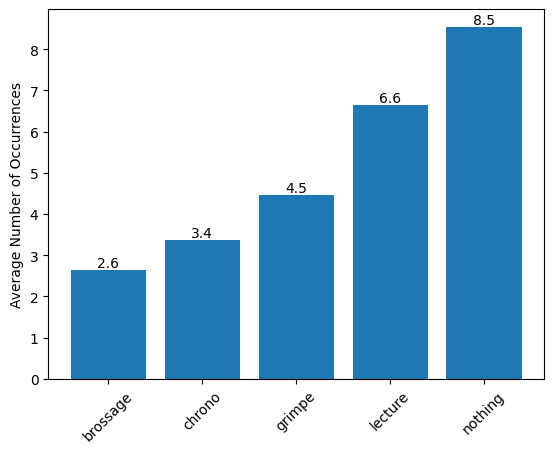

In [60]:
# Calculate number of occurrences of each action type
action_sequences = []
for video_annotation in videos_annotations:
    current_action = video_annotation[0]
    current_count = 1
    sequence_counts = {action: 0 for action in unique_classes}
    
    for action in video_annotation[1:]:
        if action != current_action:
            sequence_counts[current_action] += 1
            current_action = action
    
    # Don't forget to count the last sequence
    sequence_counts[current_action] += 1
    action_sequences.append(sequence_counts)
    
# Calculate average occurrences
average_occurrences = {action: 0 for action in unique_classes}
for action in unique_classes:
    counts = [seq[action] for seq in action_sequences]
    average_occurrences[action] = np.mean(counts)

plt.figure(figsize=ICML.single_column_figure())
plt.bar(unique_classes, list(average_occurrences.values()))
# plt.title('Average Number of Action Occurrences per Video')
plt.ylabel('Average Number of Occurrences')
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(average_occurrences.values()):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.savefig("../assets/figures/average-number-of-action-occurrences-per-video.png")

plt.show()

<div class="alert alert-info">

#### **Temporal Distribution of Actions:**

</div>

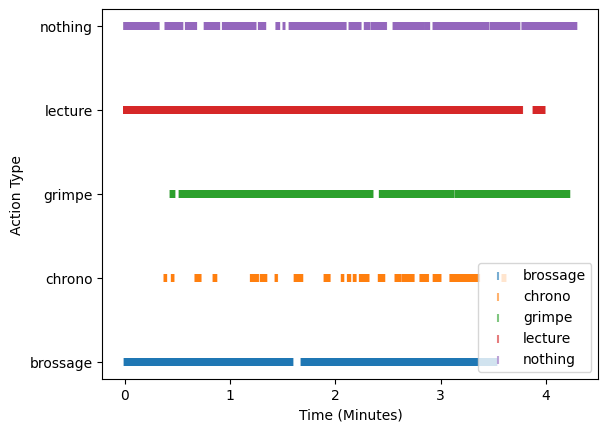

In [59]:
action_times = {action: [] for action in unique_classes}

# NOTE: iterate through all videos and extract frame indices for each action
for _, video_annotations in annotated_videos_dataset:
    video_action_times = []
    current_frame = 0
    for annotation in video_annotations:
        action = annotation
        action_times[action].append(current_frame)
        current_frame += 1

plt.figure(figsize=ICML.single_column_figure())

# Convert frames to time in minutes
for action, frames in action_times.items():
    time_in_minutes = [frame / 25 / 60 for frame in frames]  # Convert frames to minutes
    plt.scatter(time_in_minutes, [action] * len(frames), label=action, alpha=0.6, marker='|')

# plt.title('Temporal Distribution of Actions')
plt.xlabel('Time (Minutes)')
plt.ylabel('Action Type')

plt.legend()

plt.savefig("../assets/figures/temporal-distribution-of-actions.png")

plt.show()

<div class="alert alert-info">

#### **Popular Datasets:**

</div>

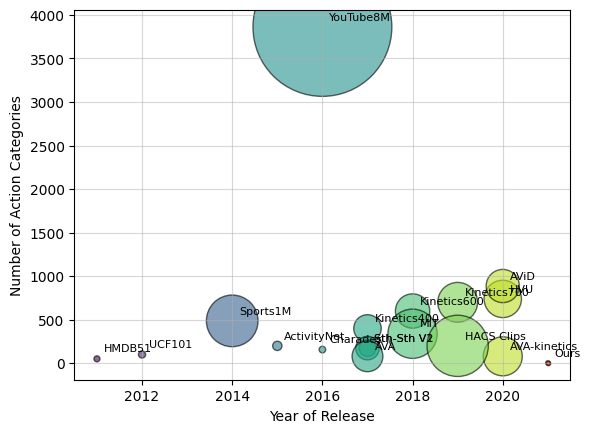

In [ ]:
import numpy as np
import pandas as pd

data = {
    'Dataset': ['Ours', 'HMDB51', 'UCF101', 'Sports1M', 'ActivityNet', 'YouTube8M', 'Charades', 'Kinetics400', 'Kinetics600', 'Kinetics700', 'Sth-Sth V1', 'Sth-Sth V2', 'AVA', 'AVA-kinetics', 'MIT', 'HACS Clips', 'HVU', 'AViD'],
    'Year': [2021, 2011, 2012, 2014, 2015, 2016, 2016, 2017, 2018, 2019, 2017, 2017, 2017, 2020, 2018, 2019, 2020, 2020],
    'Samples': [22, 7000, 13300, 1100000, 28000, 8000000, 9800, 306000, 482000, 650000, 108500, 220800, 385000, 624000, 1000000, 1550000, 572000, 450000],
    'Actions': [4, 51, 101, 487, 200, 3862, 157, 400, 600, 700, 174, 174, 80, 80, 339, 200, 739, 887]
}

dataframe = pd.DataFrame(data)

dataframe['SamplesInMillions'] = dataframe['Samples'] / 1000000

plt.figure(figsize=ICML.single_column_figure())


min_size = 10

max_size = 10000

sizes = min_size + (dataframe['SamplesInMillions'] - dataframe['SamplesInMillions'].min()) / (dataframe['SamplesInMillions'].max() - dataframe['SamplesInMillions'].min()) * (max_size - min_size)

scatter = plt.scatter(dataframe['Year'], dataframe['Actions'], s=sizes, alpha=0.6, c=dataframe['Year'], cmap='viridis', edgecolors='black')

plt.scatter(dataframe["Year"][0], dataframe["Actions"][0], s=sizes[0], alpha=0.6, c='red', edgecolors='black')

# NOTE: add labels
for i, txt in enumerate(dataframe['Dataset']):
    plt.annotate(txt, (dataframe['Year'][i], dataframe['Actions'][i]), xytext=(5, 5), textcoords='offset points', fontsize=8)

size_legend_values = [0.01, 0.1, 1, 8]

size_legend_sizes = min_size + (np.array(size_legend_values) - dataframe['SamplesInMillions'].min()) / (dataframe['SamplesInMillions'].max() - dataframe['SamplesInMillions'].min()) * (max_size - min_size)

size_legend_sizes = [max(s, min_size) for s in size_legend_sizes]

plt.xlabel('Year of Release')
plt.ylabel('Number of Action Categories')

plt.grid(alpha=0.5)

plt.savefig("../assets/figures/popular-datasets.png")

plt.show()

In [68]:
from experiments.helpers.training_results_visualization import write_latex_table

data = {
    'Dataset': ['Ours', 'HMDB51', 'UCF101', 'Sports1M', 'ActivityNet', 'YouTube8M', 'Charades', 'Kinetics400', 'Kinetics600', 'Kinetics700', 'Sth-Sth V1', 'Sth-Sth V2', 'AVA', 'AVA-kinetics', 'MIT', 'HACS Clips', 'HVU', 'AViD'],
    'Year': [2021, 2011, 2012, 2014, 2015, 2016, 2016, 2017, 2018, 2019, 2017, 2017, 2017, 2020, 2018, 2019, 2020, 2020],
    'Samples': [22, 7000, 13300, 1100000, 28000, 8000000, 9800, 306000, 482000, 650000, 108500, 220800, 385000, 624000, 1000000, 1550000, 572000, 450000],
    'Actions': [4, 51, 101, 487, 200, 3862, 157, 400, 600, 700, 174, 174, 80, 80, 339, 200, 739, 887]
}

indices_to_remove = [5, 6, 7, 8, 9, 10]

for key in data:
    data[key] = [value for i, value in enumerate(data[key]) if i not in indices_to_remove]

dataframe = pd.DataFrame(data)

write_latex_table(
    dataframe=dataframe,
    path="../assets/tables/popular-datasets.tex",
    caption="A list of popular video datasets.",
)

<div class="alert alert-info">

#### **Segmentations Visualizations Examples:**

</div>

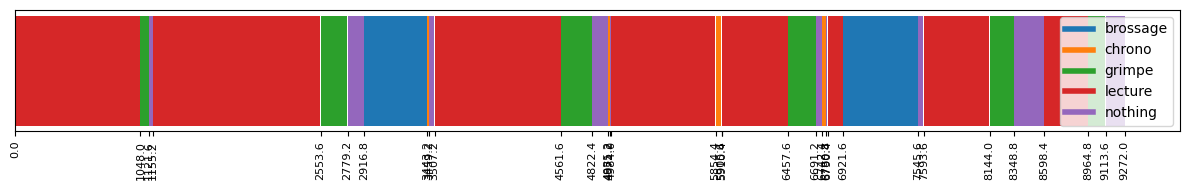

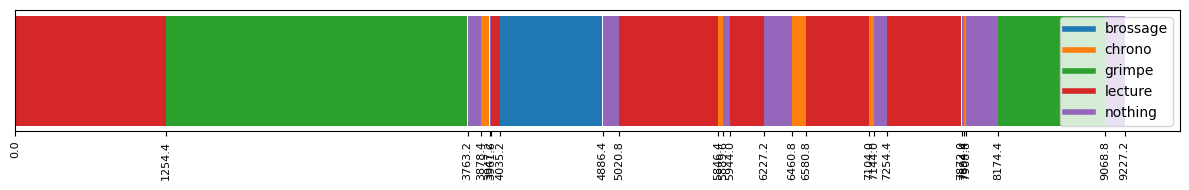

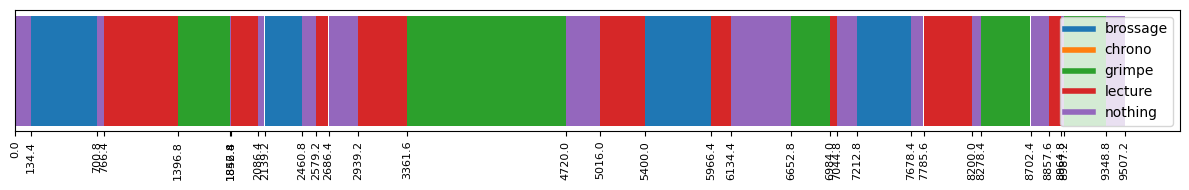

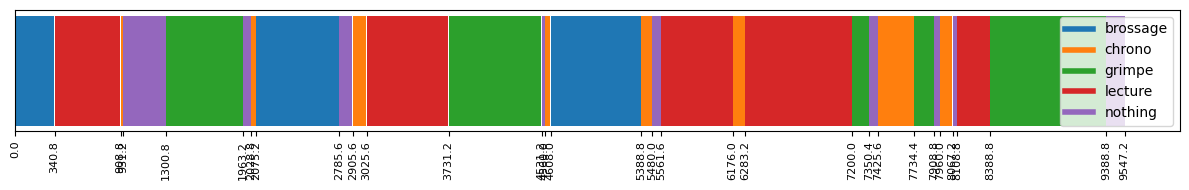

In [55]:
visualizer = SegmentationVisualizer(label_encoder.classes_)

random_indices = np.random.choice(22, 4, replace=False)

for index in random_indices:
    visualizer.plot_segmentation(annotated_videos_dataset[index][1], VIDEO_FPS)